In [243]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, precision_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [244]:
#Checking wich GPU is beeing used

!nvidia-smi

Fri Dec 24 15:18:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   25C    P8    17W / 250W |   1420MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [245]:
#Load data
data_speaker_dir_false = 'dialogue/Dataset/VoiceDetection/mfcc/NO_SPEECH_30000_samples.npy'
labels_dir_false = 'dialogue/Dataset/VoiceDetection/mfcc/NO_SPEECH_30000_labels.npy'

data_speaker_dir_true = 'dialogue/Dataset/VoiceDetection/mfcc/CLEAN_SPEECH_10000_samples.npy'
labels_dir_true = 'dialogue/Dataset/VoiceDetection/mfcc/CLEAN_SPEECH_10000_labels.npy'

data_speaker_dir_true_2 = 'dialogue/Dataset/VoiceDetection/mfcc/SPEECH_WITH_MUSIC_10000_samples.npy'
labels_dir_true_2 = 'dialogue/Dataset/VoiceDetection/mfcc/SPEECH_WITH_MUSIC_10000_labels.npy'

data_speaker_dir_true_3 = 'dialogue/Dataset/VoiceDetection/mfcc/SPEECH_WITH_NOISE_10000_samples.npy'
labels_dir_true_3 = 'dialogue/Dataset/VoiceDetection/mfcc/SPEECH_WITH_NOISE_10000_labels.npy'

data_speaker = np.load(data_speaker_dir_false, allow_pickle = True)
labels = np.load(labels_dir_false, allow_pickle = True)

data_speaker = np.concatenate((data_speaker, np.load(data_speaker_dir_true, allow_pickle= True)))
labels = np.concatenate((labels, np.load(labels_dir_true, allow_pickle= True)))

data_speaker = np.concatenate((data_speaker, np.load(data_speaker_dir_true_2, allow_pickle= True)))
labels = np.concatenate((labels, np.load(labels_dir_true_2, allow_pickle= True)))

data_speaker = np.concatenate((data_speaker, np.load(data_speaker_dir_true_3, allow_pickle= True)))
labels = np.concatenate((labels, np.load(labels_dir_true_3, allow_pickle= True)))
#dim = data_speaker.shape
#data_speaker = data_speaker.reshape(dim[0],dim[1]* dim[2])
print(data_speaker.shape)
print(labels)

(60017, 40, 44)
[False False False ...  True  True  True]


In [267]:
test_labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")
test_labels.drop(test_labels.columns[[0]], axis=1, inplace=True)
test_labels = test_labels['isSpeaking'].to_numpy()
test_dir = 'dialogue/Dataset/VoiceDetection/mfcc/test.npy'
test_data_speaker = np.load(test_dir, allow_pickle = True)
#dim = test_data_speaker.shape
#test_data_speaker = test_data_speaker.reshape(dim[0],dim[1]* dim[2])
print(test_data_speaker.shape)

(2300, 40, 44)


In [247]:
print(np.unique(test_labels, return_counts=True))

(array([False,  True]), array([1256, 1044]))


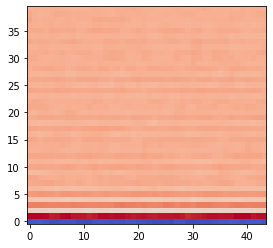

In [248]:
from matplotlib import cm
fig, ax = plt.subplots()
mfcc_data = data_speaker[1]
cox = ax.imshow(mfcc_data, interpolation = 'nearest', cmap = cm.coolwarm, origin = 'lower')
plt.show()

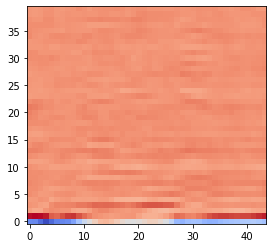

In [249]:
from matplotlib import cm
fig, ax = plt.subplots()
mfcc_data = test_data_speaker[200]
cox = ax.imshow(mfcc_data, interpolation = 'nearest', cmap = cm.coolwarm, origin = 'lower')
plt.show()

In [250]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_val, y_train, y_val = train_test_split(data_speaker, labels, test_size = 0.2, random_state = 23)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
#X_test = test_data_speaker
#y_test = test_labels
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [251]:
# false_data_dir = 'dialogue/Dataset/VoiceDetection/mfcc/only_false_speakers.npy'
# false_labels_dir = 'dialogue/Dataset/VoiceDetection/mfcc/only_false_labels.npy'

# X_train = np.concatenate((X_train, np.load(false_data_dir, allow_pickle= True)))
# y_train = np.concatenate((y_train, np.load(false_labels_dir, allow_pickle= True)))

# X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
# X_train = np.concatenate((X_train, X_temp))
# y_train = np.concatenate((y_train, y_temp))

In [252]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
#X_train = X_train.unsqueeze_(-1)
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
#X_val = X_val.unsqueeze_(-1)
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
#X_test = X_test.unsqueeze_(-1)
y_test = torch.from_numpy(y_test).float()

print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)

torch.Size([38410, 40, 44]) torch.Size([38410])


In [253]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=7, stride = 1, padding= 3, padding_mode= 'zeros') #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=5, stride = 1, padding = 2, padding_mode= 'zeros') #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(60, 70, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')
        self.conv4 = nn.Conv1d(70, 80, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')

        
        self.fc1 = nn.Linear(160, 100) #Fully-connected classifier layer
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        x = F.relu(F.max_pool1d(self.conv4(x), 2))
        x = x.reshape(len(x), -1)
        #point A
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 7)

In [254]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [255]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [256]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [257]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#X_train = X_train.to(device)
#y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [258]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [259]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results_acc = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val'])
Results_loss = pd.DataFrame(columns = ['Epoch', 'Loss_train', 'Loss_val'])
Results_recall = pd.DataFrame(columns = ['Epoch', 'Recall_val'])
Results_prec = pd.DataFrame(columns = ['Epoch', 'Prec_val'])

for epoch in range(50):
    
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    
    for x, y in train_dl:

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = CNN(x)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
        
    if epoch % 1 == 0:

        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
        train_loss = criterion(y_pred,y)
    
        y_val_pred = CNN(X_val)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val)
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
        
        Confusion = confusion_matrix(y_val.cpu(),y_val_pred.ge(.5).view(-1).cpu())
    
        val_recall_voice = Confusion[1][1]/(Confusion[1][1] + Confusion[1][0])
        val_prec_voice = Confusion[1][1]/(Confusion[0][1] + Confusion[1][1])

        val_recall_Novoice = Confusion[0][0]/(Confusion[0][0] + Confusion[0][1])
        val_prec_Novoice = Confusion[0][0]/(Confusion[1][0] + Confusion[0][0])

        Acc = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc)}
        Loss = {'Epoch': epoch, 'Loss_train': round_tensor(train_loss), 'Loss_val': round_tensor(val_loss)}
        Recall = {'Epoch': epoch, 'Recall_val_voice': round_tensor(val_recall_voice), "Recall_val_Novoice": round_tensor(val_recall_Novoice)}
        Prec = {'Epoch': epoch,'Prec_val_voice': round_tensor(val_prec_voice), 'Prec_val_Novoice': round_tensor(val_prec_Novoice)}

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')
        
        Results_acc = Results_acc.append(Acc, ignore_index=True)
        Results_loss = Results_loss.append(Loss, ignore_index=True)
        Results_recall = Results_recall.append(Recall, ignore_index=True)
        Results_prec = Results_prec.append(Prec, ignore_index=True)

epoch 0
Train set - loss: 0.654, accuracy: 0.753
val  set - loss: 0.408, accuracy: 0.82

epoch 1
Train set - loss: 0.533, accuracy: 0.826
val  set - loss: 0.375, accuracy: 0.836

epoch 2
Train set - loss: 0.448, accuracy: 0.841
val  set - loss: 0.357, accuracy: 0.846

epoch 3
Train set - loss: 0.38, accuracy: 0.853
val  set - loss: 0.343, accuracy: 0.854

epoch 4
Train set - loss: 0.335, accuracy: 0.861
val  set - loss: 0.333, accuracy: 0.86

epoch 5
Train set - loss: 0.297, accuracy: 0.867
val  set - loss: 0.323, accuracy: 0.864

epoch 6
Train set - loss: 0.245, accuracy: 0.873
val  set - loss: 0.314, accuracy: 0.869

epoch 7
Train set - loss: 0.206, accuracy: 0.878
val  set - loss: 0.306, accuracy: 0.874

epoch 8
Train set - loss: 0.179, accuracy: 0.883
val  set - loss: 0.3, accuracy: 0.876

epoch 9
Train set - loss: 0.156, accuracy: 0.887
val  set - loss: 0.296, accuracy: 0.877

epoch 10
Train set - loss: 0.149, accuracy: 0.89
val  set - loss: 0.292, accuracy: 0.877

epoch 11
Train 

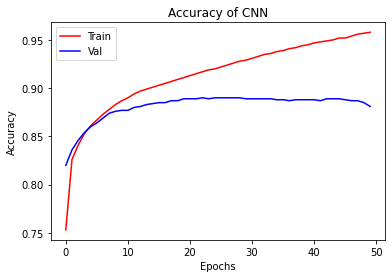

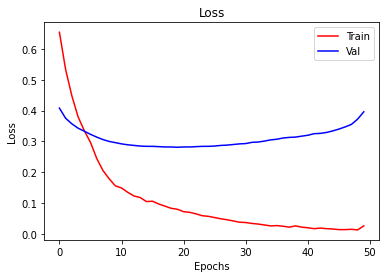

In [260]:
plt.plot(Results_acc.Epoch,Results_acc.Acc_train,'r',Results_acc.Epoch,Results_acc.Acc_val,'b')
plt.legend(['Train','Val'])
plt.title('Accuracy of CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_loss.Epoch,Results_loss.Loss_train,'r',Results_loss.Epoch,Results_loss.Loss_val,'b')
plt.legend(['Train','Val'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

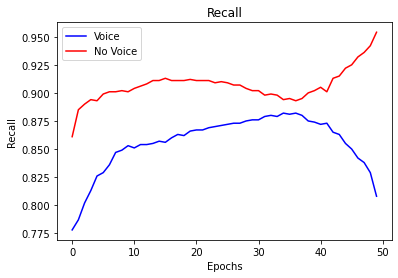

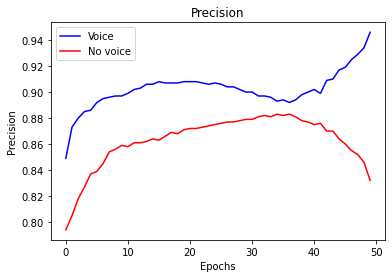

In [261]:
plt.plot(Results_recall.Epoch , Results_recall.Recall_val_voice,'b', Results_recall.Recall_val_Novoice,'r')
plt.legend(['Voice', 'No Voice'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_prec.Epoch,Results_prec.Prec_val_voice,'b', Results_prec.Prec_val_Novoice,'r')
plt.legend(['Voice', 'No voice'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.show()

In [262]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.83      0.95      0.89      5988
       Voice       0.95      0.81      0.87      6016

    accuracy                           0.88     12004
   macro avg       0.89      0.88      0.88     12004
weighted avg       0.89      0.88      0.88     12004



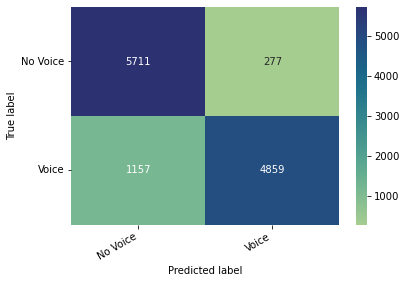

In [263]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [264]:
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.83      0.95      0.89      4762
       Voice       0.94      0.81      0.87      4841

    accuracy                           0.88      9603
   macro avg       0.89      0.88      0.88      9603
weighted avg       0.89      0.88      0.88      9603



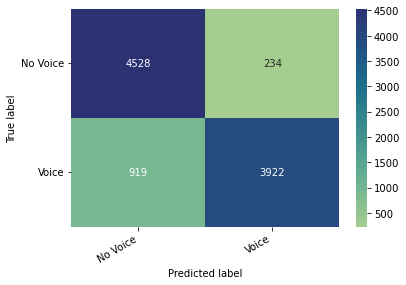

In [265]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [266]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
